In [32]:
import pandas
from fppylec import main, forecast, optimization
from datetime import datetime, timedelta
import plotly.express as px
import logging
from tabulate import tabulate
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
%load_ext autoreload
%autoreload 2

layout = {
    'showlegend': False,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2,  'zerolinecolor':'white'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'white'},
    'template': 'plotly_dark',
}
px.defaults.color_discrete_sequence = px.colors.qualitative.T10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Inputs

In [33]:
# Filenames (correct folder)
batch = 0
nb_houses = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30,
             35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
inputfiles = [f'data/{x}_{batch}.pickle' for x in nb_houses]
outputfile = 'result.pickle'

# Simulation period
start = '2019-01-15 00:00:00'
start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
end = '2019-12-31 23:45:00'
end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
f_horizon = timedelta(days=2) - timedelta(minutes=15)
f_train_period = timedelta(days=14)

# Simulation variable (forecasting method)
f_method = forecast.ma
f_kwarg = {}
control_func = optimization.pool

# Running simulation

In [34]:
_start_time = datetime.now()
metrics = pandas.DataFrame()

for inputfile, nb_house in zip(inputfiles, nb_houses):
    print(f'Using {inputfile} out of {inputfiles}')
    df = pandas.read_pickle(inputfile)
    df = df.loc[:, ['vo_houses_kW', 'vo_pv_coef']]

    # Assert timing
    assert start in df.index
    assert end in df.index
    assert int(pandas.infer_freq(df.index)[:-1]) == 15

    # Assert overall consumption (20000kWh is a lot)
    assert df['vo_houses_kW'].sum() * 15/60 / nb_house < 20000, f'Total conso {df["vo_houses_kW"].sum()}'

    # Assert PV
    assert df['vo_pv_coef'].min() >= 0
    assert df['vo_pv_coef'].max() <= 1.01, f'Max PV coef = {df["vo_pv_coef"].max()}'
    
    ###########
    ### RUN ###
    ###########
    pv_capacity = 1.25 * nb_house  # kW
    battery_kWh = 3 * nb_house   # kWh
    battery_kW = 2 * nb_house  # kW
    result = main.main(df.asfreq('15T'), start, end, pv_capacity, battery_kWh, battery_kW,
                  f_method, f_kwarg, f_horizon, f_train_period, control_func)
    
    # Save
    result['index'] = nb_house
    result['filename'] = inputfile
    result['algo'] = f'{f_method.__name__}'
    result['f_kwarg'] = str(f_kwarg)
    result['batch'] = batch
    result['start'] = start.strftime('%Y-%m-%d %H:%M:%S')
    result['end'] = end.strftime('%Y-%m-%d %H:%M:%S')
    result['pv_capacity'] = pv_capacity
    result['battery_kWh'] = battery_kWh
    result['battery_kW'] = battery_kW
    metrics = metrics.append(result, ignore_index=True)

print(tabulate(
    metrics[['index', 'MAPE_%', 'MAPE_9a8p_%', 'MASE',
             'scons_%', 'ssuff_%',
             'ME_kW', 'MAE_kW']],
    headers='keys', tablefmt='psql'))
print('')
print('------')
_time_elapsed = datetime.now() - _start_time
print('Total time elapsed (hh:mm:ss) {}'.format(_time_elapsed))
print('')

Using data/10_0.pickle out of ['data/10_0.pickle', 'data/30_0.pickle', 'data/95_0.pickle']
Time elapsed (hh:mm:ss.ms) 0:00:02.127358

Using data/30_0.pickle out of ['data/10_0.pickle', 'data/30_0.pickle', 'data/95_0.pickle']
Time elapsed (hh:mm:ss.ms) 0:00:02.002632

Using data/95_0.pickle out of ['data/10_0.pickle', 'data/30_0.pickle', 'data/95_0.pickle']
Time elapsed (hh:mm:ss.ms) 0:00:01.910367

+----+---------+----------+---------------+--------+-----------+-----------+---------+----------+
|    |   index |   MAPE_% |   MAPE_9a8p_% |   MASE |   scons_% |   ssuff_% |   ME_kW |   MAE_kW |
|----+---------+----------+---------------+--------+-----------+-----------+---------+----------|
|  0 |      10 |    34.72 |         25.66 |   2.24 |   90.926  |   40.0862 |   -0.07 |     1.49 |
|  1 |      30 |    22.94 |         17.46 |   2.29 |   93.9402 |   42.3279 |    0.26 |     2.96 |
|  2 |      95 |    20.56 |         13.52 |   3.03 |   94.0428 |   43.8616 |   -0.53 |     7.94 |
+----+----

# Visualization

In [35]:
metrics

,MAE_kW,MAPE_%,MAPE_9a8p_%,MASE,ME_kW,algo,batch,battery_kW,battery_kWh,end,f_kwarg,filename,index,pv_capacity,scons_%,scons_%_nobatt,ssuff_%,ssuff_%_nobatt,start
0,1.49,34.72,25.66,2.24,-0.07,ma,0.0,20.0,30.0,2019-05-10 23:45:00,{},data/10_0.pickle,10.0,12.50,90.926046,75.296366,40.086166,28.700762,2019-05-01 00:00:00
1,2.96,22.94,17.46,2.29,0.26,ma,0.0,60.0,90.0,2019-05-10 23:45:00,{},data/30_0.pickle,30.0,37.50,93.940205,73.080396,42.327864,28.424538,2019-05-01 00:00:00
2,7.94,20.56,13.52,3.03,-0.53,ma,0.0,190.0,285.0,2019-05-10 23:45:00,{},data/95_0.pickle,95.0,118.75,94.042765,72.147183,43.861629,29.124082,2019-05-01 00:00:00


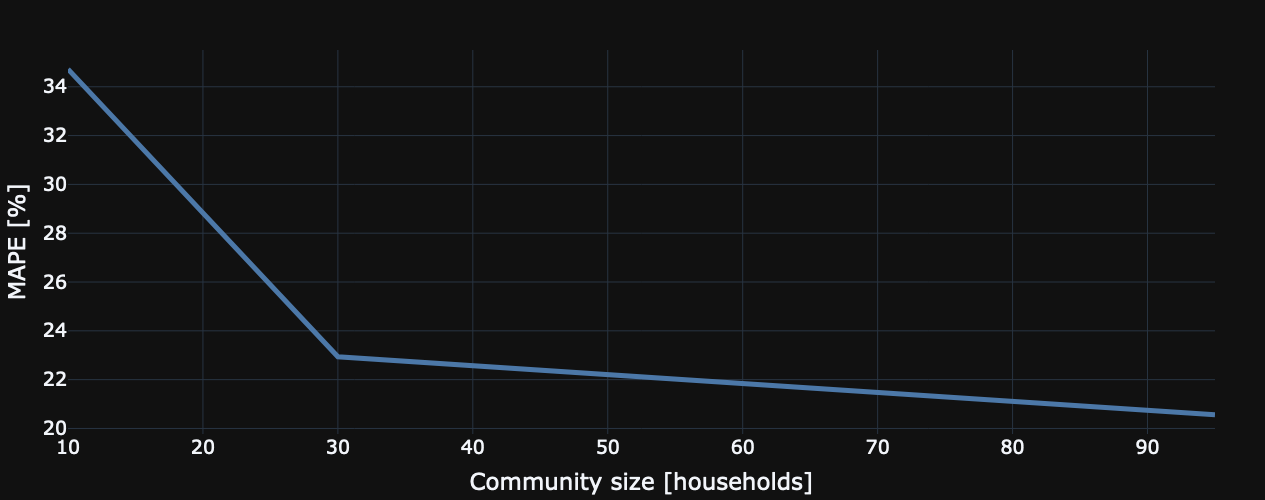

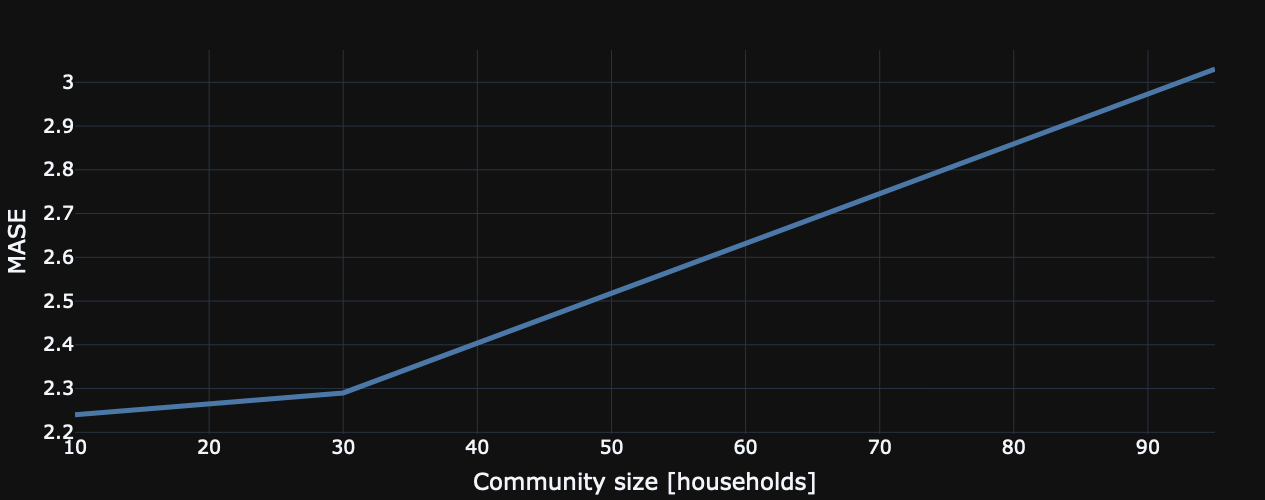

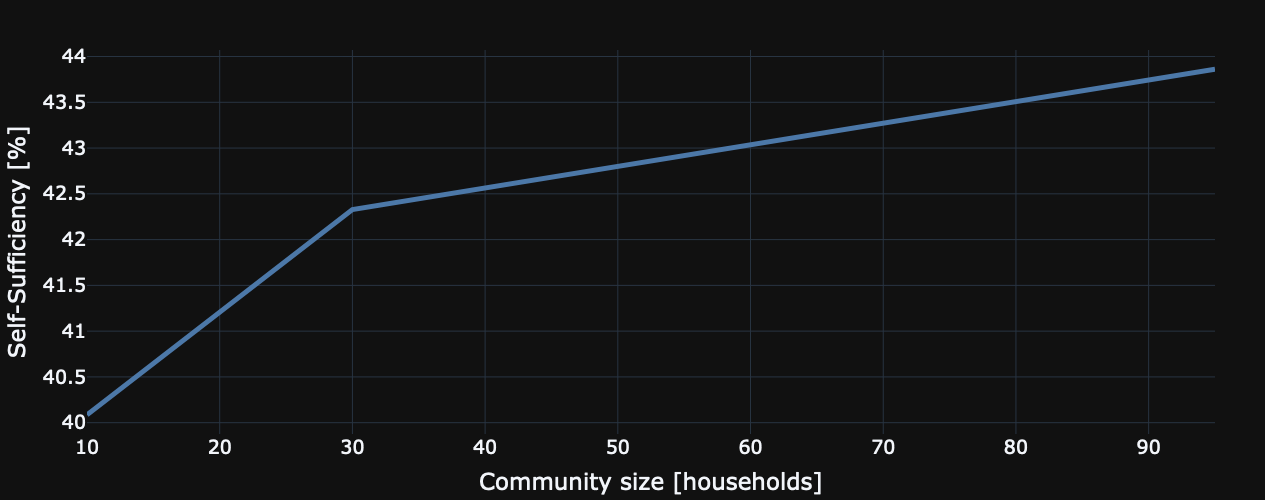

In [36]:
# plot metrics as a function of nb houses
def plot_f_community_size(_df, y_name, y_label):
    fig = px.line(_df, x='index', y=y_name,
                  line_group='algo', color='algo')
    fig.update_layout(
        layout,
        height=500,
        width=800,
        showlegend=False,
        yaxis={'title': y_label})
    fig.update_xaxes({'title': 'Community size [households]'})
    fig.update_traces({'line': {'width' : 5}})
    fig.show()
plot_f_community_size(metrics, 'MAPE_%', 'MAPE [%]')
plot_f_community_size(metrics, 'MASE', 'MASE')
plot_f_community_size(metrics, 'ssuff_%', 'Self-Sufficiency [%]')

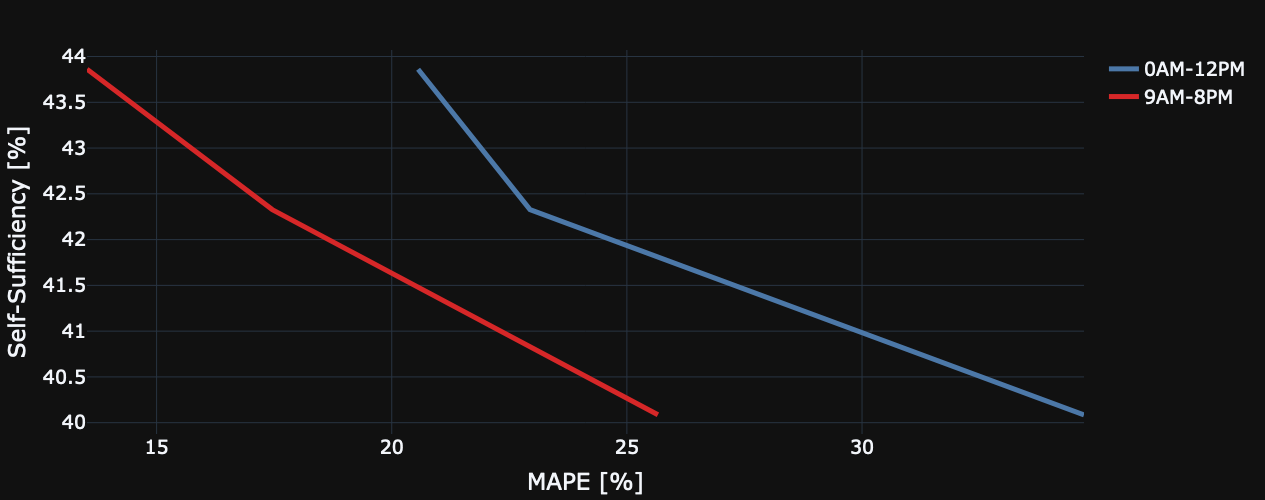

In [37]:
# Draw relation between value and quality
fig = px.line(metrics, x='MAPE_%', y='ssuff_%')
fig.data[0].update({'name': '0AM-12PM', 'showlegend': True})
trace = px.line(metrics, x='MAPE_9a8p_%', y='ssuff_%').data[0]
trace.update({'name': '9AM-8PM',
              'showlegend': True,
              'line': {'color': '#d62728'}})
fig.add_trace(trace)
fig.update_layout(
    layout,
    height=500,
    width=800,
    showlegend=True,
    yaxis={'title': 'Self-Sufficiency [%]'})
fig.update_xaxes({'title': 'MAPE [%]'})
fig.update_traces({'line': {'width' : 5}})
fig.show()

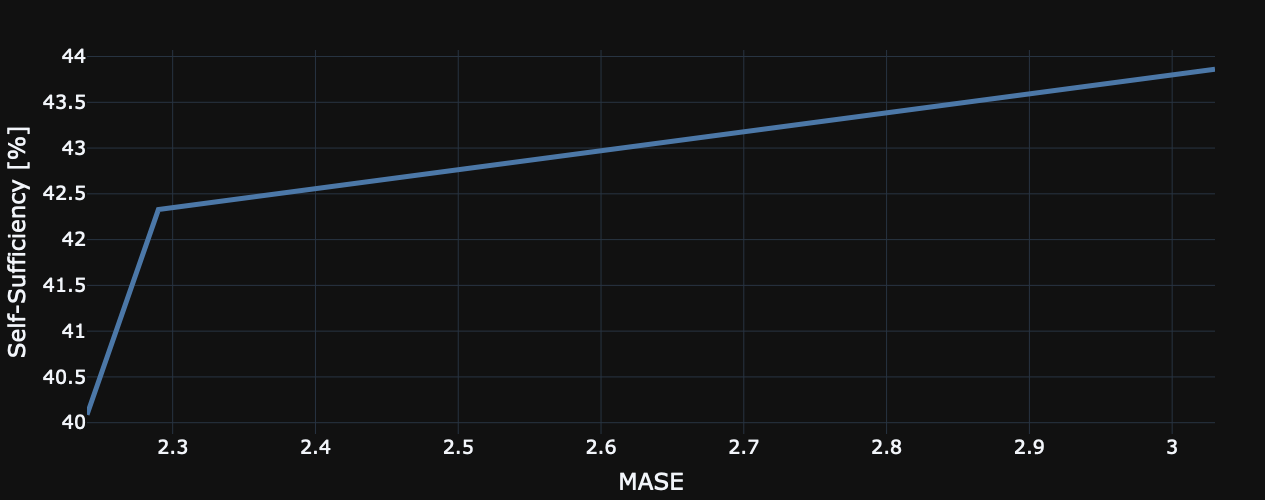

In [38]:
# Draw relation between value and quality
fig = px.line(metrics, x='MASE', y='ssuff_%',
              line_group='algo', color='algo')
fig.update_layout(
    layout,
    height=500,
    width=800,
    showlegend=False,
    yaxis={'title': 'Self-Sufficiency [%]'})
fig.update_xaxes({'title': 'MASE'})
fig.update_traces({'line': {'width' : 5}})
fig.show()

In [39]:
metrics.to_pickle('result.pickle')